<a href="https://colab.research.google.com/github/kgoel59/kgoel59/blob/main/MLipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
random_state = 1

In [2]:
batch_size = 32

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [5]:
#9af0571c31ff9ceb598ff74bd1c79cb40323b87e
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Prerequesties

In [6]:
# Basic system and data handling libraries
import os
import string
import requests
import tarfile
import pandas as pd
import numpy as np

In [7]:
# Text processing libraries
from bs4 import BeautifulSoup
import re

In [8]:
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [9]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [10]:
# tensorflow
from transformers import BertTokenizer, TFBertModel
from keras.layers import TextVectorization
import tensorflow as tf

In [11]:
# gensim
import gensim
from gensim import corpora


In [12]:
#nlp
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

In [13]:
# nltk dataset
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [14]:
# spacy
import spacy
from spacy.matcher import Matcher
from textblob import TextBlob

In [15]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [16]:
# setup gpu

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


## PART1

### Collect and Prepare the Data - `Xy`


#### Dataset collection and annotation

In [ ]:
def download_dataset(url: str, extract_to: str):
    """Download and extract the dataset from a given URL."""

    # Extract the file name from the URL
    tar_gz_path = url.split("/")[-1]

    # Download the dataset
    print(f"Downloading dataset from {url}...")
    response = requests.get(url, stream=True)
    with open(tar_gz_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)

    # Create directory if it does not exist
    os.makedirs(extract_to, exist_ok=True)

    # Extract the downloaded file
    print(f"Extracting dataset to {extract_to}...")
    with tarfile.open(tar_gz_path, "r:gz") as tar:
        tar.extractall(path=extract_to)

    # Optionally, remove the tar.gz file after extraction
    os.remove(tar_gz_path)

    print("Dataset downloaded and extracted successfully.")

def read_reviews(directory: str, label: int):
    """Read reviews from specified directory and return as DataFrame."""
    reviews = []
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory)]
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            review_text = file.read()
            reviews.append((review_text, label))
    return pd.DataFrame(reviews, columns=['review', 'sentiment'])

def get_dataset(url: str, extract_to: str):
    """Check if the dataset exists locally. If not, download and extract it. Then, load into pandas DataFrame."""
    if not os.path.exists(extract_to):
        download_dataset(url, extract_to)

    pos_train = read_reviews(os.path.join(extract_to, 'aclImdb' ,  'train', 'pos'), 'positive')
    neg_train = read_reviews(os.path.join(extract_to, 'aclImdb' ,  'train', 'neg'), 'negative')
    pos_test = read_reviews(os.path.join(extract_to,  'aclImdb' ,  'test',  'pos'), 'positive')
    neg_test = read_reviews(os.path.join(extract_to,  'aclImdb' ,  'test',  'neg'), 'negative')

    # Combine into single DataFrame
    Xy = pd.concat([pos_train, neg_train, pos_test, neg_test], ignore_index=True)

    # Optionally shuffle the data
    Xy = Xy.sample(frac=1, random_state=random_state).reset_index(drop=True)

    print("Datasets loaded successfully.")
    return Xy

In [ ]:
imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
output_dir = "imdb_dataset"
Xy = get_dataset(imdb_url, output_dir)

Datasets loaded successfully.


#### Data View

In [ ]:
Xy.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
Xy.head()

,review,sentiment
0,"""Porgy & Bess"" was the very first movie my par...",positive
1,The 1960's TV series Bewitched owes it's idea ...,positive
2,When I first got my N64 when I was five or six...,positive
3,I grew up on this movie and I can remember whe...,positive
4,this is a dreadful adaption of Charles Kingsle...,negative


,review,sentiment
0,"""Porgy & Bess"" was the very first movie my par...",positive
1,The 1960's TV series Bewitched owes it's idea ...,positive
2,When I first got my N64 when I was five or six...,positive
3,I grew up on this movie and I can remember whe...,positive
4,this is a dreadful adaption of Charles Kingsle...,negative


In [ ]:
Xy['review'][1]

"The 1960's TV series Bewitched owes it's idea from this movie. This is the movie that Jimmy Stewart & Kim Novak made right after they were cast together in Vertigo by Alfred Hitchcock. This one is not as obsessive as that one but Novak is just as captivating.<br /><br />This was Jack Lemmons 10th movie and he is good in support here as well as Ernie Kovacs. The movie has a lot of good things about it. Hermine Gingold is very good in this movie, almost as good in support here as she was in The Music Man. The cast is very solid.<br /><br />This movie has a late 1950's New York City feel & a cat that is as hexing as any feline in any movie. It is well worth watching as it is a love story with all the emotion of any, & a little magic too boot.<br /><br />It is not Vertigo but I think because it followed that movie, viewers then did not rate it as good as it deserved - sure am glad that William Asher saw it, so that the 1960's series got created. I am not so glad about what Will Ferrell di

Duplicates

In [ ]:
Xy.duplicated().sum()

418

Sentiment count

In [ ]:
Xy['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

#### Pre-Processing

Remove Duplicates

In [ ]:
Xy=Xy.drop_duplicates()
Xy.shape

(49582, 2)

Convert text into clauses

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
# Modify the tokenizer's rules to handle specific cases
@nlp.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == ',':
            doc[token.i+1].is_sent_start = False
    return doc

In [ ]:
# Add the rule before parsing
nlp.add_pipe("set_custom_boundaries", before='parser')

<function __main__.set_custom_boundaries(doc)>

Denoise

In [ ]:
# Remove whitespace
def remove_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# Remove the html strips
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove url data
def remove_url(text):
    text=re.sub(r"https?://\S+|www\.\S+",'',text)
    return text

# Remove special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Remove Punctuation
def remove_punctuation(text):
    for i in string.punctuation:
        if i in text:
            text = text.replace(i,'')
    return text

In [ ]:
# Remove the noisy text
def denoise_text(text):
    text = remove_punctuation(remove_special_characters(remove_url(remove_between_square_brackets(remove_html(remove_whitespace(text))))))
    return text

Standardize

In [ ]:
# convert text to lowercase
def convert_lowercase(text):
    return text.lower()

In [ ]:
# standardize text
def standardize_text(text):
  text = convert_lowercase(text)
  return text


Remove stop words and Lemmatize

In [ ]:
negation_words = {'no', 'not', 'nor', 'never', "don't", "aren't", "isn't", "wasn't", "weren't", "haven't", "hasn't", "didn't", "doesn't", "won't", "wouldn't", "can't", "couldn't"}

In [ ]:
custom_stop_words = ['movie', 'film', 'flick' 'one', 'in', 'it', 'have', 'who', 'as', 'he']

In [ ]:
stopwords_set = set(stopwords.words('english') + custom_stop_words).difference(negation_words)
lemmatizer = WordNetLemmatizer()

In [ ]:
lemmatized = {}
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatize_tokens = []

    for word in tokens:
        if word in lemmatized:
            lemmatize_tokens.append(word)
        else:
          if word not in stopwords_set:
            lemmatized_word = lemmatizer.lemmatize(word)

            if lemmatized_word not in lemmatized:
              lemmatized[lemmatized_word] = [word]
            else:
              if word not in lemmatized[lemmatized_word]:
                lemmatized[lemmatized_word].append(word)
            lemmatize_tokens.append(lemmatized_word)

    return lemmatize_tokens


Apply

In [ ]:
def preprocess(text):
    """
    Extracts clauses from a sentence using spaCy's dependency parser and preprocess.
    """
    text_clauses = []
    doc = nlp(text)

    for sent in doc.sents:
      sentence_clauses = []

      for token in sent:
        if 'VERB' in token.pos_:
            clause = ' '.join([tok.text for tok in token.subtree])
            processed_clause = ' '.join(lemmatize(standardize_text(denoise_text(clause))))
            if len(processed_clause) > 0:
              sentence_clauses.append(processed_clause)

      if len(sentence_clauses) > 0:
        text_clauses.append(sentence_clauses)

    return text_clauses

In [ ]:
preprocess(Xy['review'][0])

[['parent ever took see', 'see'],
 ['even tender age 5 year greatly moved drama cried aloud screen crown please nt take be',
  'cried aloud screen crown',
  'please nt take be'],
 ['see one tv broadcast porgy be many year ago',
  'remember wonderful wonderful'],
 ['waiting wishing hoping one day might copy porgy be nt look like happen',
  'wishing hoping one day might copy porgy be',
  'hoping one day might copy porgy be',
  'one day might copy porgy be',
  'nt look like happen',
  'like happen'],
 ['obviously enough public interest warrant release', 'warrant release'],
 ['year remember sure seems like not alone', 'sure seems like not alone'],
 ['brimming human emotion jealousy lust anger bravery determination'],
 ['buried',
  'deserves be brought forth light new audience admire',
  'be brought forth light new audience admire',
  'old audience relish']]

In [ ]:
Xy['clauses'] = Xy['review'].apply(preprocess)

Pre-Process Result

In [ ]:
Xy.head()

,review,sentiment,clauses
0,"""Porgy & Bess"" was the very first movie my par...",positive,"[[parent ever took see, see], [even tender age..."
1,The 1960's TV series Bewitched owes it's idea ...,positive,"[[bewitched owes], [jimmy stewart kim novak ma..."
2,When I first got my N64 when I was five or six...,positive,"[[first got n64 five six, first got n64 five s..."
3,I grew up on this movie and I can remember whe...,positive,[[grew remember brother used play backyard pre...
4,this is a dreadful adaption of Charles Kingsle...,negative,"[[put bluntly awful], [song epsecially high co..."


In [ ]:
Xy['clauses'][1]

[['bewitched owes'],
 ['jimmy stewart kim novak made right cast together vertigo alfred hitchcock',
  'cast together vertigo alfred hitchcock'],
 ['lot good thing'],
 ['late 1950 new york city feel cat hexing feline',
  'late 1950 new york city feel cat hexing feline',
  'hexing feline'],
 ['watching love story emotion'],
 ['think followed viewer not rate good deserved sure glad william asher saw 1960 series got created',
  'followed',
  'followed viewer not rate good deserved',
  'deserved',
  'william asher saw',
  '1960 series got created']]

#### Label Encoding

In [ ]:
LE = LabelEncoder()
Xy['sentiment_encoded'] = LE.fit_transform(Xy['sentiment'])

In [ ]:
Xy

,review,sentiment,clauses,sentiment_encoded
0,"""Porgy & Bess"" was the very first movie my par...",positive,"[[parent ever took see, see], [even tender age...",1
1,The 1960's TV series Bewitched owes it's idea ...,positive,"[[bewitched owes], [jimmy stewart kim novak ma...",1
2,When I first got my N64 when I was five or six...,positive,"[[first got n64 five six, first got n64 five s...",1
3,I grew up on this movie and I can remember whe...,positive,[[grew remember brother used play backyard pre...,1
4,this is a dreadful adaption of Charles Kingsle...,negative,"[[put bluntly awful], [song epsecially high co...",0
...,...,...,...,...
49995,"Two sorcerers battle in the fourth dimension,o...",positive,"[[destroy earth, save], [offer plenty cheese],...",1
49996,BLACK EYE (2 outta 5 stars) Unimaginatively-fi...,negative,"[[unimaginatively filmed, black eye 2 outta 5 ...",0
49997,This film has been compared to the hilarious B...,negative,[[film compared hilarious british comedy fish ...,0
49998,"this may not be War & Peace, but the two Acade...",positive,[[i fallen in love as child gone back without ...,1


#### Save

In [ ]:
import json
with open('lemmatized.json', 'w') as fp:
  json.dump(lemmatized, fp)

In [ ]:
Xy.to_csv('data.csv')

## PART2

### Loading Text

In [ ]:
import json
with open('lemmatized.json') as json_file:
    lemmatized = json.load(json_file)

In [ ]:
Xy = pd.read_csv('data.csv', index_col=0)

In [ ]:
import ast
Xy['clauses'] = Xy['clauses'].apply(ast.literal_eval)

In [ ]:
Xy.head()

,review,sentiment,clauses,sentiment_encoded
0,"""Porgy & Bess"" was the very first movie my par...",positive,"[[parent ever took see, see], [even tender age...",1
1,The 1960's TV series Bewitched owes it's idea ...,positive,"[[bewitched owes], [jimmy stewart kim novak ma...",1
2,When I first got my N64 when I was five or six...,positive,"[[first got n64 five six, first got n64 five s...",1
3,I grew up on this movie and I can remember whe...,positive,[[grew remember brother used play backyard pre...,1
4,this is a dreadful adaption of Charles Kingsle...,negative,"[[put bluntly awful], [song epsecially high co...",0


In [ ]:
Xy.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review             49582 non-null  object
 1   sentiment          49582 non-null  object
 2   clauses            49582 non-null  object
 3   sentiment_encoded  49582 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 76.9 MB


### Topic Creation

#### Categories

In [ ]:
category_keywords = {
    'plot': ['plot', 'storyline', 'narrative', 'story', 'subplot', 'twist'],
    'actor': ['actor', 'actress', 'performance', 'cast', 'star', 'role', 'character', 'performer', 'leading', 'supporting'],
    'music': ['score', 'soundtrack', 'composer', 'theme', 'song', 'music', 'musical'],
    'director': ['director', 'directed', 'filmmaker', 'visionary', 'producer', 'screenwriter', 'auteur', 'helmer', 'directorial']
}


In [ ]:
def count_category_keywords(text, category_keywords):
    category_counter = {category: Counter() for category in category_keywords}

    for clause in text:

        # Increase count for each keyword found, categorized
        for token in clause:
            for category, keywords in category_keywords.items():
                if token in keywords:
                    category_counter[category][token] += 1

    return category_counter

In [ ]:
flat_clauses = []
for sentences in Xy['clauses'].to_numpy():
  for clauses in sentences:
      for clause in clauses:
       flat_clauses.append(word_tokenize(clause))

flat_clauses[0:3]

[['parent', 'ever', 'took', 'see'],
 ['see'],
 ['even',
  'tender',
  'age',
  '5',
  'year',
  'greatly',
  'moved',
  'drama',
  'cried',
  'aloud',
  'screen',
  'crown',
  'please',
  'nt',
  'take',
  'be']]

In [ ]:
category_counter = count_category_keywords(flat_clauses, category_keywords)

In [ ]:
category_counter

{'plot': Counter({'story': 28117,
          'plot': 14640,
          'twist': 2439,
          'storyline': 1670,
          'narrative': 1178,
          'subplot': 274}),
 'actor': Counter({'character': 35015,
          'actor': 15255,
          'role': 10350,
          'performance': 9172,
          'star': 8384,
          'cast': 7978,
          'actress': 3206,
          'supporting': 3132,
          'leading': 2500,
          'performer': 592}),
 'music': Counter({'music': 7016,
          'song': 4313,
          'theme': 2756,
          'score': 2378,
          'musical': 2239,
          'soundtrack': 1617,
          'composer': 235}),
 'director': Counter({'director': 12274,
          'directed': 4362,
          'producer': 2558,
          'filmmaker': 2278,
          'screenwriter': 663,
          'directorial': 257,
          'auteur': 128,
          'visionary': 47,
          'helmer': 28})}

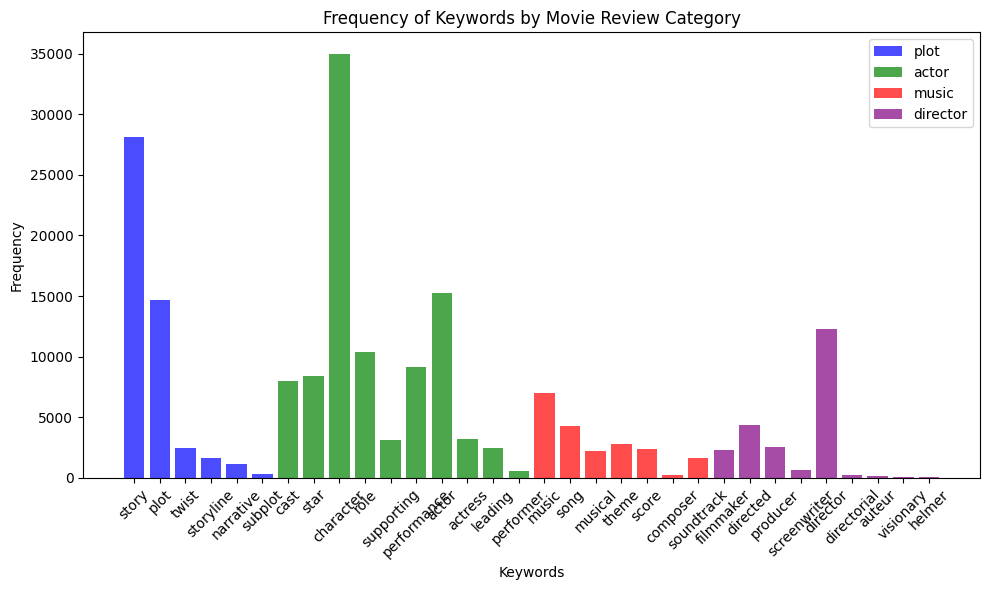

In [ ]:
# Plotting the frequencies
fig, ax = plt.subplots(figsize=(10, 6))
categories = list(category_counter.keys())
colors = ['blue', 'green', 'red', 'purple']

for i, category in enumerate(categories):
    keywords = list(category_counter[category].keys())
    frequencies = list(category_counter[category].values())
    ax.bar(keywords, frequencies, color=colors[i], label=category, alpha=0.7)

ax.set_xlabel('Keywords')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Keywords by Movie Review Category')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### LDA

In [ ]:
remove_words = set(['s','no','in','there','he','more','can','end','life','i','out','as','get','go','an','take','turn','be','so','can','more','many','film','nt','who','thing','little','not','said','say','could','think','know','give','one','way','come','first','point','back', 'br','movie','good','like','find','black','sex','time','day','m','ca','us','make','will','even','try','lot','year','old','though','away','me','man','true','stand','would','ever','never','down','here','best','see','seen','done','called','being','something','guy','every','really','going'])

In [ ]:
# Pseudo-code for keyword enrichment
def enrich_with_keywords(text, category_keywords):
    enriched_text = []
    for clause in text:
        enriched_clause = []
        for token in clause:
            if token not in remove_words:
                found = False
                for category, keywords in category_keywords.items():
                    if token in keywords:
                      enriched_clause.extend([token] * 10)
                      found = True
                      break
                if not found:
                  enriched_clause.append(token)
        enriched_text.append(enriched_clause)
    return enriched_text

In [ ]:
# Apply to your data
enriched_clauses = enrich_with_keywords(flat_clauses, category_keywords)

In [ ]:
len(enriched_clauses)

1337944

In [ ]:
dictionary = corpora.Dictionary(enriched_clauses)
corpus = [dictionary.doc2bow(text) for text in enriched_clauses]

# Train the LDA model
num_topics = 10  # Set the number of topics (aspects) you want to extract
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics (aspects) with their top words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.123*"performance" + 0.042*"theme" + 0.035*"well" + 0.016*"acting" + 0.014*"thought"')
(1, '0.435*"story" + 0.027*"storyline" + 0.009*"understand" + 0.009*"tell" + 0.008*"based"')
(2, '0.126*"cast" + 0.038*"filmmaker" + 0.033*"score" + 0.032*"over" + 0.014*"family"')
(3, '0.039*"directed" + 0.018*"love" + 0.012*"making" + 0.009*"scene" + 0.008*"girl"')
(4, '0.179*"director" + 0.016*"better" + 0.014*"now" + 0.013*"right" + 0.012*"got"')
(5, '0.249*"actor" + 0.212*"plot" + 0.162*"role" + 0.052*"actress" + 0.041*"musical"')
(6, '0.089*"have" + 0.087*"star" + 0.025*"watch" + 0.023*"much" + 0.020*"while"')
(7, '0.543*"character" + 0.068*"song" + 0.041*"producer" + 0.037*"leading" + 0.009*"human"')
(8, '0.019*"made" + 0.017*"look" + 0.012*"show" + 0.012*"want" + 0.010*"woman"')
(9, '0.123*"music" + 0.056*"supporting" + 0.037*"twist" + 0.023*"soundtrack" + 0.020*"real"')


In [ ]:
import pyLDAvis.gensim_models

# Assuming you have a trained lda_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.211093 -0.104873       1        1  15.320138
3     -0.193692  0.022994       2        1  13.147554
6     -0.177317  0.007062       3        1  11.424695
4     -0.037181  0.017536       4        1   9.483963
0      0.038792  0.140612       5        1   9.411450
7      0.165726 -0.305875       6        1   8.444839
1      0.169325  0.129067       7        1   8.353567
5      0.255009  0.080346       8        1   8.332299
2     -0.036064  0.211555       9        1   8.319943
9      0.026495 -0.198425      10        1   7.761552, topic_info=           Term           Freq          Total Category  logprob  loglift
115   character  409017.000000  409017.000000  Default  30.0000  30.0000
74        story  324219.000000  324219.000000  Default  29.0000  29.0000
1090      actor  184694.000000  184694.000000  Default  28.0000  28.0000
102        plot  157533.000000  157533.000000  Default  27.0000  27.0000
1509   director  151379.000000  151379.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
68         feel    8861.646361   15888.437199  Topic10  -4.3575   1.9721
506      around    7554.520312   13581.175492  Topic10  -4.5171   1.9694
50          new    5174.044611   12717.887506  Topic10  -4.8956   1.6566
1612        run    3927.202795    6808.233046  Topic10  -5.1713   2.0058
438      people    4137.785937   33488.243361  Topic10  -5.1191   0.4650

[421 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2867     10  0.999793       1
810       7  0.999820      10
194       9  0.999750       2
1574      8  0.999571  accept
789       3  0.950564     act
...     ...       ...     ...
3102      3  0.999733   wrong
1291      1  0.999775     yet
144       1  0.324524   young
144       2  0.623817   young
144       8  0.051583   young

[522 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 7, 5, 1, 8, 2, 6, 3, 10])

In [ ]:
def categorize_topics(topics, category_keywords):
    topic_categories = []
    for topic in topics:
        # Extract words from topic string
        words = [word.split('*')[1].replace('"', '').strip() for word in topic[1].split('+')]
        # Count occurrences of each category's keywords in the topic
        category_count = {category: sum(word in words for word in keywords) for category, keywords in category_keywords.items()}
        # Determine the best category for the topic
        best_category = max(category_count, key=category_count.get)
        topic_categories.append((topic, best_category, category_count[best_category]))
    return topic_categories

# Categorize each topic
categorized_topics = categorize_topics(topics, category_keywords)

In [ ]:
category_count = Counter()
for i in [topic[1] for topic in categorized_topics]:
    category_count[i] += 1

category_count

Counter({'actor': 5, 'plot': 2, 'director': 2, 'music': 1})

In [ ]:
topic_mapping = {}

for topic in categorized_topics:
    topic_mapping[topic[0][0]] = topic[1]

topic_mapping

{0: 'actor',
 1: 'plot',
 2: 'actor',
 3: 'director',
 4: 'director',
 5: 'actor',
 6: 'actor',
 7: 'actor',
 8: 'plot',
 9: 'music'}

In [ ]:
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

In [ ]:
# Assuming 'doc_topics' contains lists of tuples with (topic, probability)
# and 'topic_mapping' maps topic indices to category names.

aspects = []

for doc in doc_topics:  # Loop through each document's topics
    highest_prob = {}  # Dictionary to hold the highest probability for each category

    for topic in doc:
        category = topic_mapping[topic[0]]  # Get the category name using the topic index
        prob = topic[1]  # Get the probability

        # If this category is not in highest_prob or current prob is higher, update it
        if category not in highest_prob or prob > highest_prob[category]:
            highest_prob[category] = prob

    # Store the highest probabilities for this document
    aspects.append([(cat, highest_prob[cat]) for cat in sorted(highest_prob)])

# The 'aspects' list will now contain the topic with the highest probability for each category in each document


In [ ]:
aspects[0:5]

[[('actor', 0.03333714),
  ('director', 0.36665186),
  ('music', 0.03333714),
  ('plot', 0.36665103)],
 [('actor', 0.1), ('director', 0.1), ('music', 0.1), ('plot', 0.1)],
 [('actor', 0.28145498), ('music', 0.4638568), ('plot', 0.19099851)],
 [('actor', 0.52466166),
  ('director', 0.025018735),
  ('music', 0.025018737),
  ('plot', 0.2751877)],
 [('actor', 0.05000187),
  ('director', 0.05000187),
  ('music', 0.5499832),
  ('plot', 0.05000187)]]

In [ ]:
def max_aspect(doc_topics):
    highest_prob = {}  # Dictionary to store the highest probability for each category

    for topic, prob in doc_topics:
        category = topic  # Map the topic index to a category name

        # Check if this category is not in the dictionary or if the current probability is higher than the stored one
        if category not in highest_prob or prob > highest_prob[category]:
            highest_prob[category] = prob

    # Finding the category with the maximum probability
    max_category = max(highest_prob, key=highest_prob.get)  # Get the category with the highest probability
    return max_category  # Return the category and its highest probability


In [ ]:
data = Xy['clauses'].to_numpy()
rows = []

# Iterate over each review
for review_index, review in enumerate(data):
    # Iterate over each sentence in the review
    for sentence_index, sentence in enumerate(review):
        # Iterate over each clause in the sentence
        for clause_index, clause in enumerate(sentence):
            # Safely access the corresponding aspect
            aspect_index = review_index * len(review) * len(sentence) + sentence_index * len(sentence) + clause_index
            aspect = aspects[aspect_index] if aspect_index < len(aspects) else None

            if type(aspect) is not type(None):
            # Create a dictionary for each row
                row = {
                    'Review Number': review_index,
                    'Sentence Number': sentence_index,
                    'Clause': clause,
                    'Aspect': max_aspect(aspect)
                }
                rows.append(row)

# Create DataFrame from list of dictionaries
df = pd.DataFrame(rows, columns=['Review Number', 'Sentence Number', 'Clause', 'Aspect'])

In [ ]:
df[df['Review Number'] == 0]

,Review Number,Sentence Number,Clause,Aspect
0,0,0,parent ever took see,director
1,0,0,see,actor
2,0,1,even tender age 5 year greatly moved drama cri...,actor
3,0,1,cried aloud screen crown,music
4,0,1,please nt take be,actor
5,0,2,see one tv broadcast porgy be many year ago,music
6,0,2,remember wonderful wonderful,actor
7,0,3,waiting wishing hoping one day might copy porg...,actor
8,0,3,wishing hoping one day might copy porgy be,plot
9,0,3,hoping one day might copy porgy be,plot


### Save

In [ ]:
df.to_csv("data_aspects.csv")

In [ ]:
Xy.to_csv("data_2.csv")

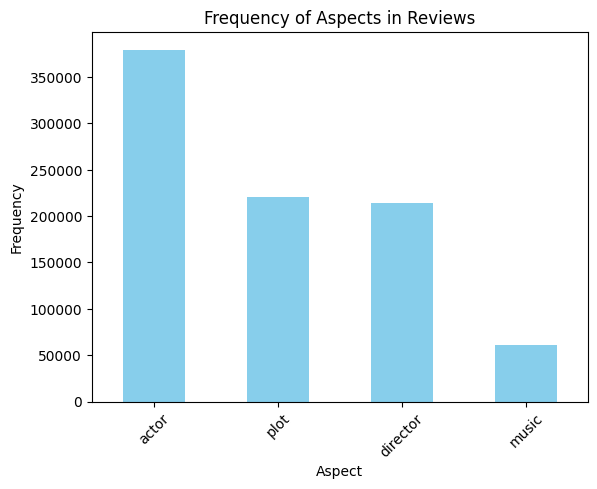

In [ ]:
aspect_counts = df['Aspect'].explode().apply(lambda x: x).value_counts()
# Plotting the bar chart
aspect_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Aspects in Reviews')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## PART 3

### Loading Text

In [17]:
Xy = pd.read_csv('/content/drive/MyDrive/data_2.csv', index_col=0)

In [18]:
import ast
Xy['clauses'] = Xy['clauses'].apply(ast.literal_eval)

In [19]:
Xy.head()

,review,sentiment,clauses,sentiment_encoded
0,"""Porgy & Bess"" was the very first movie my par...",positive,"[[parent ever took see, see], [even tender age...",1
1,The 1960's TV series Bewitched owes it's idea ...,positive,"[[bewitched owes], [jimmy stewart kim novak ma...",1
2,When I first got my N64 when I was five or six...,positive,"[[first got n64 five six, first got n64 five s...",1
3,I grew up on this movie and I can remember whe...,positive,[[grew remember brother used play backyard pre...,1
4,this is a dreadful adaption of Charles Kingsle...,negative,"[[put bluntly awful], [song epsecially high co...",0


In [20]:
aspects = pd.read_csv('/content/drive/MyDrive/data_aspects.csv', index_col=0)

In [21]:
aspects.head()

,Review Number,Sentence Number,Clause,Aspect
0,0,0,parent ever took see,director
1,0,0,see,actor
2,0,1,even tender age 5 year greatly moved drama cri...,actor
3,0,1,cried aloud screen crown,music
4,0,1,please nt take be,actor


### CNN Model

In [26]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

Denoise & Standardize

In [28]:
# Remove whitespace
def remove_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# Remove the html strips
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove url data
def remove_url(text):
    text=re.sub(r"https?://\S+|www\.\S+",'',text)
    return text

# Remove special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Remove Punctuation
def remove_punctuation(text):
    for i in string.punctuation:
        if i in text:
            text = text.replace(i,'')
    return text

In [29]:
# Remove the noisy text
def denoise_text(text):
    text = remove_punctuation(remove_special_characters(remove_url(remove_between_square_brackets(remove_html(remove_whitespace(text))))))
    return text

In [30]:
# convert text to lowercase
def convert_lowercase(text):
    return text.lower()

In [31]:
# standardize text
def standardize_text(text):
  text = convert_lowercase(text)
  return text

In [32]:
data_clean = [standardize_text(denoise_text(review)) for review in Xy.review]

<ipython-input-28-1c25d8df05a4>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel, AutoTokenizer

# Load pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'
model = TFDistilBertModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set maximum sequence length
max_seq_length = 512

# Example sentences
sentences = Xy[['review']].to_numpy().ravel()

# Tokenize sentences and get BERT embeddings
embeddings = []
for sentence in sentences:
    # Tokenize sentence and ensure maximum length is 512
    tokenized_text = tokenizer.encode(sentence, add_special_tokens=True, max_length=max_seq_length, truncation=True)
    tokens_tensor = tf.constant([tokenized_text])
    outputs = model(tokens_tensor)
    pooled_output = outputs[0][:, 0, :]  # Extract pooled output (sentence-level embedding)
    embeddings.append(pooled_output)

# Combine embeddings into a single tensor
combined_tensor = tf.concat(embeddings, axis=0)

# Now 'combined_tensor' contains BERT embeddings for all sentences with a maximum length of 512 tokens
print(combined_tensor.shape)  # Shape: (num_sentences, embedding_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
combined_tensor

<tf.Tensor: shape=(9, 768), dtype=float32, numpy=
array([[ 0.09454463, -0.14739595, -0.07183232, ..., -0.07970361,
         0.64515215,  0.34577224],
       [-0.3766079 , -0.35007092,  0.20923607, ..., -0.0397191 ,
         0.35626948,  0.5268057 ],
       [ 0.11598985, -0.17935288,  0.13017417, ..., -0.10069375,
         0.47312477,  0.10054556],
       ...,
       [-0.09608705, -0.28159314,  0.04645567, ...,  0.10272673,
         0.6389869 ,  0.33317283],
       [-0.1143447 , -0.30620527,  0.12555203, ...,  0.05899057,
         0.5490793 ,  0.33636343],
       [ 0.09144378, -0.10897975,  0.03200766, ...,  0.02127891,
         0.7528258 ,  0.46138272]], dtype=float32)>

In [ ]:
from keras import layers
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, Xy.sentiment_encoded, test_size = 0.2, random_state = random_state)

In [ ]:
class DCNN(tf.keras.Model):

    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.pool_1 = layers.GlobalMaxPool1D()
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.pool_2 = layers.GlobalMaxPool1D()
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool_3 = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool_1(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool_2(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool_3(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = len(set(train_labels))

DROPOUT_RATE = 0.2

In [ ]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [ ]:
Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ABSA",

    # track hyperparameters and run metadata with wandb.config
    config={
        "type": "CNN",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 5,
        "batch_size": batch_size
    }
)

# [optional] use wandb.config as your config
config = wandb.config

In [ ]:
history = Dcnn.fit(
    train_inputs,
    train_labels,
    batch_size=batch_size,
    epochs=wandb.config.epoch,
    validation_data=(test_inputs, test_labels),
    callbacks=[
        WandbMetricsLogger(log_freq=5),
        WandbModelCheckpoint("models")
    ]
)

Epoch 1/5
1240/1240 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8584

wandb: Adding directory to artifact (./models)... Done. 0.8s


1240/1240 [==============================] - 182s 142ms/step - loss: 0.3116 - accuracy: 0.8584 - val_loss: 0.2339 - val_accuracy: 0.9050
Epoch 2/5
1240/1240 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9653

wandb: Adding directory to artifact (./models)... Done. 1.9s


1240/1240 [==============================] - 104s 84ms/step - loss: 0.0984 - accuracy: 0.9653 - val_loss: 0.2547 - val_accuracy: 0.9064
Epoch 3/5
1240/1240 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9949

wandb: Adding directory to artifact (./models)... Done. 0.7s


1240/1240 [==============================] - 87s 71ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.3877 - val_accuracy: 0.8986
Epoch 4/5
1240/1240 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9957

wandb: Adding directory to artifact (./models)... Done. 0.6s


1240/1240 [==============================] - 80s 65ms/step - loss: 0.0120 - accuracy: 0.9957 - val_loss: 0.4658 - val_accuracy: 0.8977
Epoch 5/5
1240/1240 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9954

wandb: Adding directory to artifact (./models)... Done. 0.7s


1240/1240 [==============================] - 79s 64ms/step - loss: 0.0133 - accuracy: 0.9954 - val_loss: 0.4841 - val_accuracy: 0.8988


In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

310/310 [==============================] - 5s 14ms/step - loss: 0.4841 - accuracy: 0.8988
[0.48411843180656433, 0.8987597227096558]


In [ ]:
wandb.finish()

batch/accuracy,▁▃▄▅▅▅▅▆▇███▇▇▇▇████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▅▅▅▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆███
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▁▁▁
epoch/val_accuracy,▇█▂▁▂
epoch/val_loss,▁▂▅▇█
batch/accuracy,0.99547


### Save

In [ ]:
Dcnn.save('cnn_model.tf',save_format='tf')

In [ ]:
Dcnn.save_weights('cnn_model.h5')

In [ ]:
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 13273813 (50.64 MB)
Trainable params: 13273813 (50.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## PART4

### Loading Text

In [ ]:
Xy = pd.read_csv('/content/drive/MyDrive/data_2.csv', index_col=0)

In [ ]:
import ast
Xy['clauses'] = Xy['clauses'].apply(ast.literal_eval)

In [ ]:
Xy.head()

,review,sentiment,clauses,sentiment_encoded
0,"""Porgy & Bess"" was the very first movie my par...",positive,"[[parent ever took see, see], [even tender age...",1
1,The 1960's TV series Bewitched owes it's idea ...,positive,"[[bewitched owes], [jimmy stewart kim novak ma...",1
2,When I first got my N64 when I was five or six...,positive,"[[first got n64 five six, first got n64 five s...",1
3,I grew up on this movie and I can remember whe...,positive,[[grew remember brother used play backyard pre...,1
4,this is a dreadful adaption of Charles Kingsle...,negative,"[[put bluntly awful], [song epsecially high co...",0


In [ ]:
aspects = pd.read_csv('/content/drive/MyDrive/data_aspects.csv', index_col=0)

In [ ]:
aspects.head()

,Review Number,Sentence Number,Clause,Aspect
0,0,0,parent ever took see,director
1,0,0,see,actor
2,0,1,even tender age 5 year greatly moved drama cri...,actor
3,0,1,cried aloud screen crown,music
4,0,1,please nt take be,actor


### Loading Model

In [ ]:
data_clean = [standardize_text(denoise_text(review)) for review in Xy.review]

<ipython-input-23-1c25d8df05a4>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
from keras import layers
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, Xy.sentiment_encoded, test_size = 0.2, random_state = random_state)

In [ ]:
run = wandb.init(reinit=False)
artifact = run.use_artifact('karangoel59/ABSA/run_m9nqu5yt_model:v4', type='model')
artifact_dir = artifact.download()

In [ ]:
model = tf.keras.models.load_model(artifact_dir)

### Evaluation CNN Model

In [ ]:
model = Dcnn

In [ ]:
model.evaluate(test_inputs, test_labels, batch_size=batch_size)

310/310 [==============================] - 5s 15ms/step - loss: 0.4841 - accuracy: 0.8988


[0.48411843180656433, 0.8987597227096558]

In [ ]:
grouped_aspects = aspects.groupby('Review Number')['Clause'].apply(list)

In [ ]:
len(grouped_aspects)

49173

In [ ]:
preds = []
for group in grouped_aspects[0:2000]:
    encoded_clauses = [tokenizer.encode(clause) for clause in group]
    encoded_inputs = tf.keras.preprocessing.sequence.pad_sequences(encoded_clauses,
                                                                value=0,
                                                                padding="post",
                                                                maxlen=MAX_LEN)
    predictions = model.predict(encoded_inputs,verbose = 0)
    preds.append(predictions)

In [ ]:
def predict_avg(pred):
  avg = np.average(pred)
  if avg > 0.5:
    return 1
  else:
    return 0

In [ ]:
final_preds = [predict_avg(pred) for pred in preds]

In [ ]:
true_labels = Xy['sentiment_encoded'][0:2000]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_labels, final_preds)

0.765

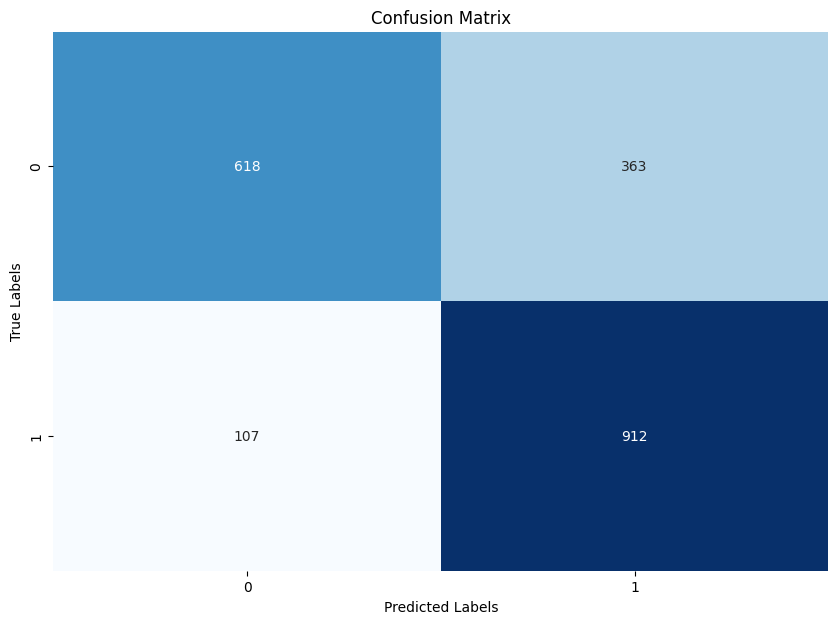

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming Xy is your DataFrame and final_preds are your predictions
conf_matrix = confusion_matrix(true_labels, final_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'fmt' is format of the numbers

# Adding labels and title for clarity
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
run.finish()